# Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('./diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Logistic Regression

<Axes: >

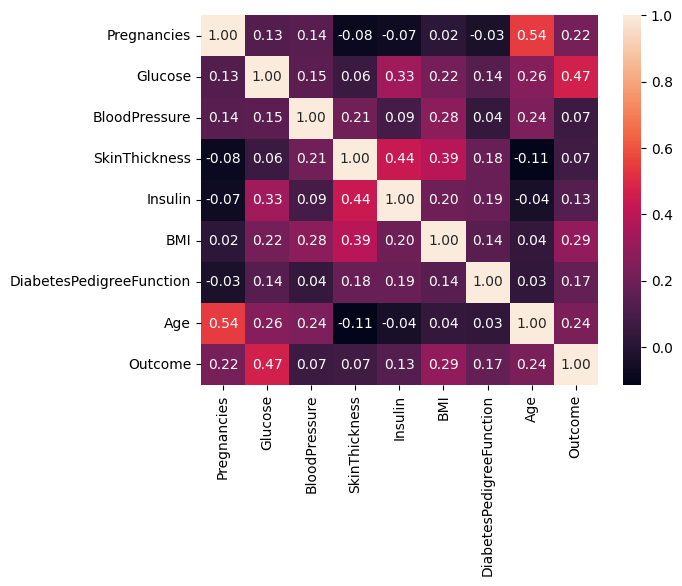

In [3]:
# Cek apakah ada hubungan antar variabel
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Memisahkan variabel prediktor dan respons

X = df.drop( 'Outcome', axis = 1)

y = df['Outcome']

In [6]:
# Scaling data

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X_ = pd.DataFrame(scale.fit_transform(X), columns = scale.get_feature_names_out())

In [7]:
# Menggunakan statsmodels

import statsmodels.api as sm

X_cons = sm.add_constant(X_)

model = sm.Logit(y, X_cons)

result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 May 2024   Pseudo R-squ.:                  0.2718
Time:                        14:07:53   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.8711      0.097     -8.986      0.000      -1.061

In [8]:
# Prediksi probabilitas dari data

prob = result.predict(X_cons)
prob

0      0.721727
1      0.048642
2      0.796702
3      0.041625
4      0.902184
         ...   
763    0.317115
764    0.318969
765    0.170416
766    0.284976
767    0.072014
Length: 768, dtype: float64

In [9]:
# Menghitung nilai Logit

logit_val = np.log((prob) / (1-prob))
logit_val

# logit val juga bisa didapat dengan memanggil result.fittedvalues

0      0.953042
1     -2.973411
2      1.365808
3     -3.136542
4      2.221729
         ...   
763   -0.767060
764   -0.758515
765   -1.582684
766   -0.919909
767   -2.556161
Length: 768, dtype: float64

# Diagnostic Checking

### Linearitas variabel kontinu terhadap logit

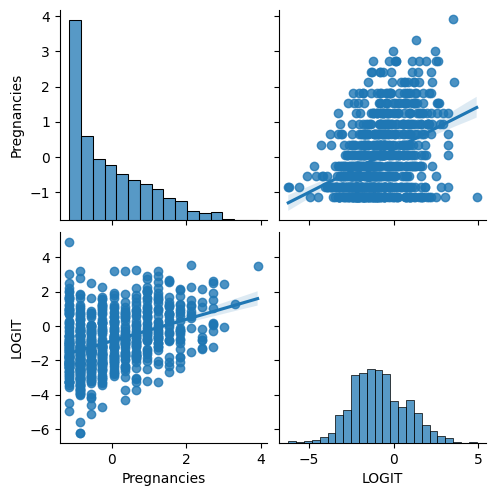

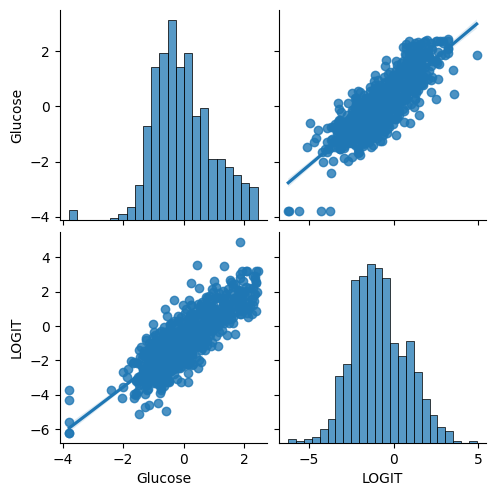

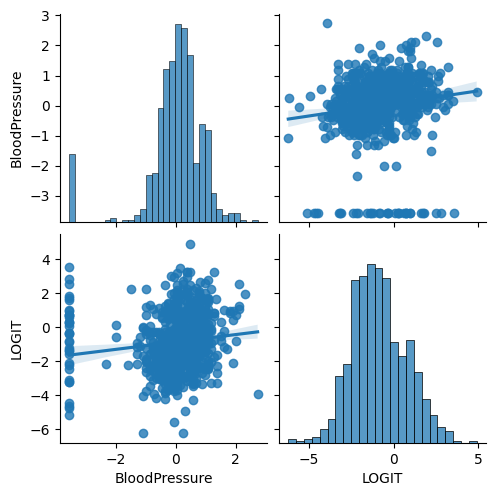

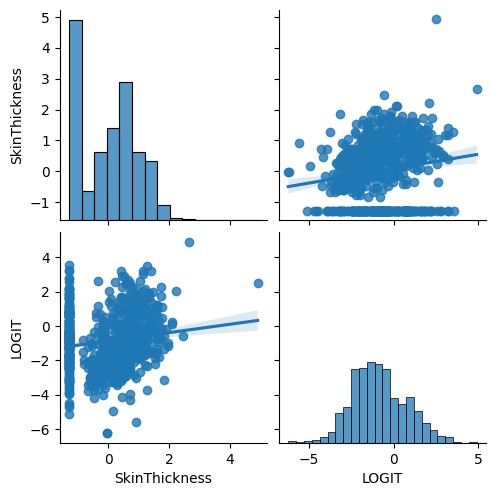

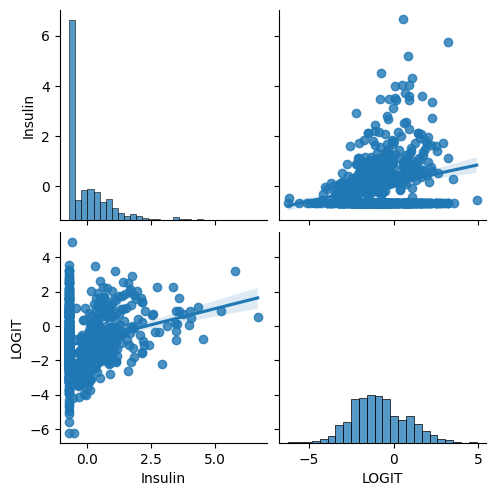

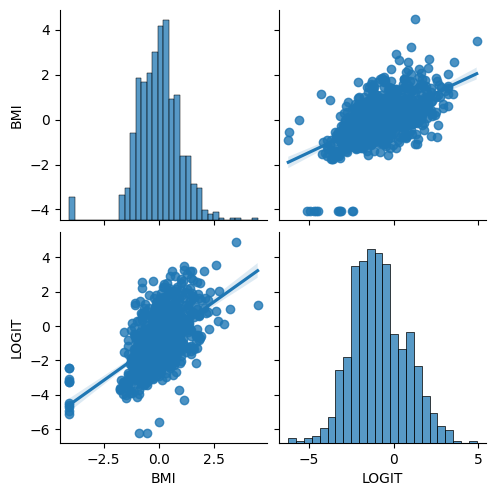

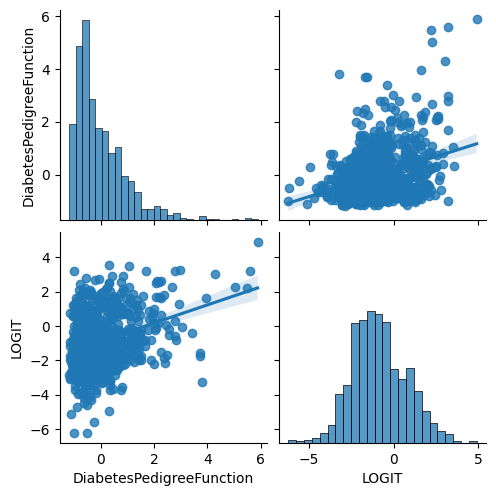

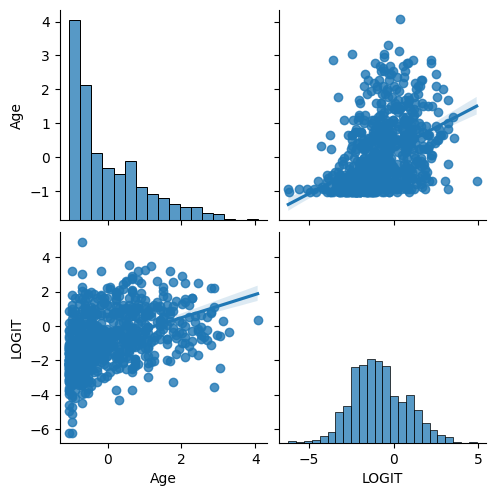

In [10]:
# Linearitas variabel independen dengan logit

linearity = X_
linearity['LOGIT'] = logit_val

for i in X_.columns[:-1]:
    sns.pairplot(X_[[i, 'LOGIT']], kind = 'reg')

### Normalitas Residual

In [11]:
# Menghitung residual

resid = 1 - prob

In [12]:
#Normalitas Residual

'''
H0  : Residuals are normally distributed
H1  : Residuals are not normally distributed
Rejet H0 if P-Value < alpha = 0,05
'''
alpha = 0.05
name = ['Chi^2', 'Two-tail probability']
normtest = sm.stats.omni_normtest(resid)
print(normtest,'\n')

if normtest.pvalue < 0.05 :
  print('Pvalue < 0.05, H0 ditolak, Residual tidak berdistribusi normal')
else  :
  print ('Pvalue > 0.05, H0 tidak ditolak, Residual  berdistribusi normal')

NormaltestResult(statistic=95.96350746004987, pvalue=1.4514066982092245e-21) 

Pvalue < 0.05, H0 ditolak, Residual tidak berdistribusi normal


### Autokorelasi

In [13]:
# Tes Autokorelasi

from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(resid)
print("Durbin-Watson test statistic:", dw_test)

Durbin-Watson test statistic: 0.27646032134618725


### Multikolinearitas

In [14]:
#No multikolinearitas
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_.values, i)
                          for i in range(len(X_.columns))]

print(vif_data)

print('\nDapat disimpulkan bahwa asumsi No Multikolinearitas tidak terpenuhi')

                    feature       VIF
0               Pregnancies  1.657620
1                   Glucose  2.962536
2             BloodPressure  1.269026
3             SkinThickness  1.507561
4                   Insulin  1.452359
5                       BMI  1.955716
6  DiabetesPedigreeFunction  1.196165
7                       Age  1.628611
8                     LOGIT  4.413933

Dapat disimpulkan bahwa asumsi No Multikolinearitas tidak terpenuhi


### Homoskedastisitas

In [16]:
# Cek Homoskedastisitas

from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(resid, X_cons)
print("Breusch-Pagan test p-value:", bp_test[1])

Breusch-Pagan test p-value: 3.7649802600185404e-150


In [23]:
# Import library klasifikasi

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

In [21]:
# Split data menjadi train dan test

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.2, random_state = 26)

In [25]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

Predict = log_reg.predict(X_test)

metrics = classification_report(y_test, Predict)
print(metrics)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       103
           1       0.75      0.65      0.69        51

    accuracy                           0.81       154
   macro avg       0.79      0.77      0.78       154
weighted avg       0.81      0.81      0.81       154



##Other Machine Learning Alghorithm

###Linear Models

In [43]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier

In [44]:
for algorithm in [LogisticRegression(), LogisticRegressionCV(), PassiveAggressiveClassifier(), Perceptron(), RidgeClassifier(), RidgeClassifierCV(), SGDClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

LogisticRegression() 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       103
           1       0.75      0.65      0.69        51

    accuracy                           0.81       154
   macro avg       0.79      0.77      0.78       154
weighted avg       0.81      0.81      0.81       154

LogisticRegressionCV() 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       103
           1       0.77      0.59      0.67        51

    accuracy                           0.81       154
   macro avg       0.79      0.75      0.76       154
weighted avg       0.80      0.81      0.80       154

PassiveAggressiveClassifier() 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       103
           1       0.72      0.65      0.68        51

    accuracy                           0.80       154
   macro avg       0.78      0.76      0.77     

### Linear and Quadratic Discriminant Analysis

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [46]:
for algorithm in [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

LinearDiscriminantAnalysis() 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       103
           1       0.74      0.63      0.68        51

    accuracy                           0.81       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.80      0.81      0.80       154

QuadraticDiscriminantAnalysis() 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       103
           1       0.54      0.61      0.57        51

    accuracy                           0.70       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.71      0.70      0.71       154



/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Support Vector Machines

In [39]:
from sklearn.svm import LinearSVC, NuSVC, SVC

In [40]:
for algorithm in [LinearSVC(), NuSVC(), SVC()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

LinearSVC() 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       103
           1       0.74      0.63      0.68        51

    accuracy                           0.81       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.80      0.81      0.80       154

NuSVC() 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       103
           1       0.72      0.65      0.68        51

    accuracy                           0.80       154
   macro avg       0.78      0.76      0.77       154
weighted avg       0.79      0.80      0.80       154

SVC() 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       103
           1       0.72      0.65      0.68        51

    accuracy                           0.80       154
   macro avg       0.78      0.76      0.77       154
weighted avg       0.79      0.80      0.8

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Nearest Neighbors

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
for algorithm in [KNeighborsClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

KNeighborsClassifier() 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       103
           1       0.67      0.63      0.65        51

    accuracy                           0.77       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



### Gaussian Processes

In [51]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [52]:
for algorithm in [GaussianProcessClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

GaussianProcessClassifier() 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       103
           1       0.68      0.67      0.67        51

    accuracy                           0.79       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.79      0.79       154



### Naive Bayes

In [60]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

In [61]:
for algorithm in [BernoulliNB(), GaussianNB()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

BernoulliNB() 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       103
           1       0.74      0.73      0.73        51

    accuracy                           0.82       154
   macro avg       0.80      0.80      0.80       154
weighted avg       0.82      0.82      0.82       154

GaussianNB() 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       103
           1       0.68      0.75      0.71        51

    accuracy                           0.80       154
   macro avg       0.77      0.79      0.78       154
weighted avg       0.80      0.80      0.80       154



### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [63]:
for algorithm in [DecisionTreeClassifier(), ExtraTreeClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

DecisionTreeClassifier() 
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       103
           1       0.56      0.63      0.59        51

    accuracy                           0.71       154
   macro avg       0.68      0.69      0.69       154
weighted avg       0.72      0.71      0.72       154

ExtraTreeClassifier() 
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       103
           1       0.48      0.57      0.52        51

    accuracy                           0.65       154
   macro avg       0.62      0.63      0.62       154
weighted avg       0.67      0.65      0.66       154



### Ensemble Methods

In [64]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier, HistGradientBoostingClassifier

In [65]:
for algorithm in [AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), RandomForestClassifier(), HistGradientBoostingClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

AdaBoostClassifier() 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       103
           1       0.62      0.55      0.58        51

    accuracy                           0.74       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.74      0.74       154

BaggingClassifier() 
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       103
           1       0.59      0.59      0.59        51

    accuracy                           0.73       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154

ExtraTreesClassifier() 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       103
           1       0.65      0.67      0.66        51

    accuracy                           0.77       154
   macro avg       0.74      0.75      0.74       154
weig

In [67]:
for algorithm in [
    StackingClassifier(estimators = [("hgbc", HistGradientBoostingClassifier()), ("gbc", GradientBoostingClassifier())], final_estimator = RandomForestClassifier()),
    VotingClassifier(estimators = [("hgbc", HistGradientBoostingClassifier()), ("gbc", GradientBoostingClassifier()), ("rfc", RandomForestClassifier())])
]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

StackingClassifier(estimators=[('hgbc', HistGradientBoostingClassifier()),
                               ('gbc', GradientBoostingClassifier())],
                   final_estimator=RandomForestClassifier()) 
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       103
           1       0.66      0.61      0.63        51

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.77      0.76       154

VotingClassifier(estimators=[('hgbc', HistGradientBoostingClassifier()),
                             ('gbc', GradientBoostingClassifier()),
                             ('rfc', RandomForestClassifier())]) 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       103
           1       0.71      0.63      0.67        51

    accuracy                           0.79       154
   macro avg       0.77      0.75     

### Other Boosting Algorithm

In [69]:
!pip install lightgbm

In [71]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00


In [72]:
!pip install xgboost

In [73]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [77]:
for algorithm in [LGBMClassifier(verbose = -1), CatBoostClassifier(verbose = False), XGBClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

LGBMClassifier(verbose=-1) 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       103
           1       0.63      0.63      0.63        51

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

               precision    recall  f1-score   support

           0       0.85      0.86      0.86       103
           1       0.71      0.69      0.70        51

    accuracy                           0.81       154
   macro avg       0.78      0.78      0.78       154
weighted avg       0.80      0.81      0.80       154

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=

### Neural network models

In [78]:
from sklearn.neural_network import MLPClassifier

In [79]:
for algorithm in [MLPClassifier()]:
  clf = algorithm
  clf.fit(X_train, y_train)

  predict = clf.predict(X_test)

  metrics = classification_report(y_test, predict)
  print(clf, "\n", metrics)

MLPClassifier() 
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       103
           1       0.70      0.65      0.67        51

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.76       154
weighted avg       0.79      0.79      0.79       154



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [80]:
import tensorflow as tf

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = "relu", input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
20/20 [==============================] - 2s 14ms/step - loss: 0.7147 - accuracy: 0.5668
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.6081 - accuracy: 0.7020
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.5466 - accuracy: 0.7443
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.5144 - accuracy: 0.7557
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.4960 - accuracy: 0.7557
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4856 - accuracy: 0.7606
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4788 - accuracy: 0.7573
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4738 - accuracy: 0.7606
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4712 - accuracy: 0.7606
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4690 - accuracy: 0.7638
Epoch

In [83]:
predict = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [88]:
predict = (predict >= 0.5).astype("int").reshape(-1)

In [90]:
metrics = classification_report(y_test, predict)
print(metrics)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       103
           1       0.70      0.61      0.65        51

    accuracy                           0.79       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.79      0.78       154



### With Lazy Predict

In [92]:
!pip install lazypredict

In [97]:
from lazypredict.Supervised import LazyClassifier

In [99]:
clf = LazyClassifier(verbose = 0,ignore_warnings = True, custom_metric = None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:04<00:00,  6.70it/s]

[LightGBM] [Info] Number of positive: 217, number of negative: 397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353420 -> initscore=-0.604039
[LightGBM] [Info] Start training from score -0.604039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [100]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.80,0.79,0.79,0.80,0.03
ExtraTreesClassifier,0.81,0.78,0.78,0.80,0.34
LogisticRegression,0.81,0.77,0.77,0.81,0.03
BernoulliNB,0.77,0.77,0.77,0.77,0.03
NearestCentroid,0.77,0.76,0.76,0.77,0.03
LinearSVC,0.81,0.76,0.76,0.80,0.10
LinearDiscriminantAnalysis,0.81,0.76,0.76,0.80,0.05
CalibratedClassifierCV,0.81,0.76,0.76,0.80,0.27
RidgeClassifierCV,0.81,0.76,0.76,0.80,0.03
